In [ ]:
#Importing all required libraries

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#using tensorflow framework for text classification

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install contractions
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
#importing necessary libraries for preprocessing for NLP

In [ ]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from contractions import fix
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import pandas 
tqdm.pandas()

In [ ]:
#loading given csv file in dataframe df

In [ ]:
df= pd.read_csv("bbc-text.csv")

In [ ]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
#checking shape of dataframe i.e 2225 rows and 2 columns

In [ ]:
df.shape

(2225, 2)

In [ ]:
df.groupby("category").first()

,text
category,
business,worldcom boss left books alone former worldc...
entertainment,ocean s twelve raids box office ocean s twelve...
politics,howard hits back at mongrel jibe michael howar...
sport,tigers wary of farrell gamble leicester say ...
tech,tv future in the hands of viewers with home th...


In [ ]:
# Checking the categories of target column "category"

<Axes: xlabel='count', ylabel='category'>

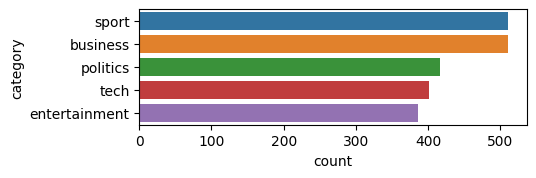

In [ ]:
plt.figure(figsize=(5,1.5))
from tensorflow.python.framework.importer import op_def_registry
sns.countplot(y=df["category"], data= df, order= df["category"].value_counts().index)

In [ ]:
# Making new feature named "label" 

In [ ]:
df["label"]= df.category

In [ ]:
#applying label encoder for geting corresponding numbers for each category

In [ ]:
encoder= LabelEncoder()
encoder.fit(df.label)
df["label"]= encoder.transform(df.label)

In [ ]:
# writing a function for preprocessing on text data

In [ ]:
def clean_data(x):
  remove_blank= x.replace("\\n", " ").replace("\t", " ")
  accented= unidecode(remove_blank)
  expand= fix(accented)
  stopwords_list= stopwords.words("english")
  tokens= word_tokenize(expand)
  clean_words= [i.lower() for i in tokens if i.lower() not in stopwords_list and(i.lower() not in punctuation) and(len(i)>2) and (i.isalpha())]
  lemmatizer= WordNetLemmatizer()
  final_text=[]
  for i in clean_words:
    lemmatized_words= lemmatizer.lemmatize(i)
    final_text.append(lemmatized_words)
  return " ".join(final_text)
    
    

In [ ]:
  >>> import nltk
  >>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

  >>> import nltk
  >>> nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Preprocessing on given data and adding new feature as "clean-text" in same dataframe

In [ ]:
df["clean_text"]= df.text.apply(lambda x: clean_data(x))

In [ ]:
df.head()

,category,text,label,clean_text
0,tech,tv future in the hands of viewers with home th...,4,future hand viewer home theatre system plasma ...
1,business,worldcom boss left books alone former worldc...,0,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,3,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,3,yeading face newcastle cup premiership side ne...
4,entertainment,ocean s twelve raids box office ocean s twelve...,1,ocean twelve raid box office ocean twelve crim...


In [ ]:
#Spliting the data into training and testing data

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(df.clean_text, df.label, test_size=0.2)

In [ ]:
#word indexing
max_words=1000

tk= Tokenizer(max_words, oov_token='##oov##')

tk.fit_on_texts(x_train)

x_train_seq= tk.texts_to_sequences(x_train)
x_test_seq= tk.texts_to_sequences(x_test)

In [ ]:
#padding sequence
#setting max length of input words as 200 and truncating(reducing) is kept as post
max_words_persent= 200
x_train_seq=pad_sequences(x_train_seq, padding="post", maxlen=max_words_persent, truncating="post")
x_test_seq=pad_sequences(x_test_seq, padding="post", maxlen=max_words_persent, truncating="post")

In [ ]:
#Early Stopping is used to avoid overfitting when training a learner with an iterative method, such as gradient descent.
# Here Early stoppage is used when val_loss does not change for 4 iterations 
es= EarlyStopping(monitor= "val_loss", patience=4)

In [ ]:
#Create a Sequential Model which includes Embedding, Con1D and Global Average Pooling1D layers.
# Using relu as activation in hidden layers
# as this is multiclassification problem, I have used softmax as activation function in output layer.

model= Sequential()
model.add(Embedding(input_dim=max_words+1, output_dim=5, input_length = max_words_persent))
model.add(Conv1D(128, 5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation= "softmax"))

In [ ]:
#Created model layers look like this.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 5)            5005      
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 128)          3328      
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 16,914
Trainable params: 16,914
Non-trainable params: 0
__________________________________________________

In [ ]:
#compiled model using 
#optimizer as adam
#loss as sparse_categorical_crossentrophy as there are multiple classes.
#Evaluation metrics as accuracy

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# This is last step of model building in which we fit training data an also pass the test data for validation(loss on test data will be evaluated simultaniously)
# As batch size passed is 50, this is example of mini batch stochastic gradient  descent
#Early stoppage is passed in callbacks to avoid over fitting

history= model.fit(
    x_train_seq,
    y_train,
    batch_size=50,
    epochs=100,
    validation_data=(x_test_seq, y_test),
    callbacks=[es]
)

Epoch 1/100
36/36 [==============================] - 2s 24ms/step - loss: 1.6021 - accuracy: 0.2185 - val_loss: 1.5804 - val_accuracy: 0.2472
Epoch 2/100
36/36 [==============================] - 1s 19ms/step - loss: 1.5073 - accuracy: 0.3275 - val_loss: 1.3554 - val_accuracy: 0.4742
Epoch 3/100
36/36 [==============================] - 1s 18ms/step - loss: 1.2033 - accuracy: 0.4831 - val_loss: 1.0486 - val_accuracy: 0.6112
Epoch 4/100
36/36 [==============================] - 1s 18ms/step - loss: 0.8629 - accuracy: 0.7242 - val_loss: 0.7439 - val_accuracy: 0.7843
Epoch 5/100
36/36 [==============================] - 1s 18ms/step - loss: 0.5479 - accuracy: 0.8264 - val_loss: 0.5157 - val_accuracy: 0.8360
Epoch 6/100
36/36 [==============================] - 1s 18ms/step - loss: 0.3474 - accuracy: 0.9045 - val_loss: 0.3613 - val_accuracy: 0.8809
Epoch 7/100
36/36 [==============================] - 1s 17ms/step - loss: 0.2207 - accuracy: 0.9478 - val_loss: 0.2903 - val_accuracy: 0.9079
Epoch 

In [80]:
#As seen above accuracy score on training data is 100% and on test data is 92.58%
# results are good and can be considered for deployment
# Evaluation is done on test data as follows

In [ ]:
model.evaluate(x_test_seq, y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9258


[0.22613167762756348, 0.9258427023887634]

In [82]:
# Prediction on testing data is done as follows
# This gives the output of probability for each class
# Higher the probability, higher is the chance of text tobe classified in that class

In [ ]:
model.predict(x_test_seq)

14/14 [==============================] - 0s 4ms/step


array([[9.98625696e-01, 4.02116575e-06, 2.79933680e-04, 1.09034579e-03,
        4.42162431e-08],
       [9.29714561e-01, 2.35479474e-02, 2.84338780e-02, 1.73704550e-02,
        9.33075149e-04],
       [4.21428759e-09, 2.69264274e-04, 6.16818652e-05, 2.47669333e-11,
        9.99669075e-01],
       ...,
       [1.07074743e-06, 1.44612045e-10, 9.97409999e-01, 1.24729180e-15,
        2.58899340e-03],
       [5.49441902e-05, 9.90089297e-01, 6.65814241e-06, 8.96333065e-03,
        8.85640795e-04],
       [9.89297748e-01, 3.33262687e-05, 1.04375025e-02, 2.24036761e-04,
        7.32312128e-06]], dtype=float32)

In [ ]:
# Plotting graph between training loss and testing loss through all iterations

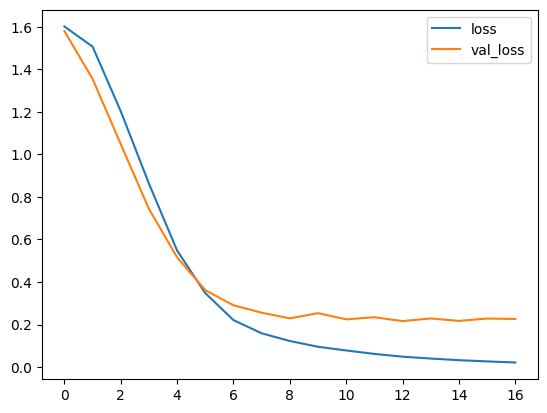

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

In [83]:
# Plotting graph between training accuracy and testing accuracy through all iterations

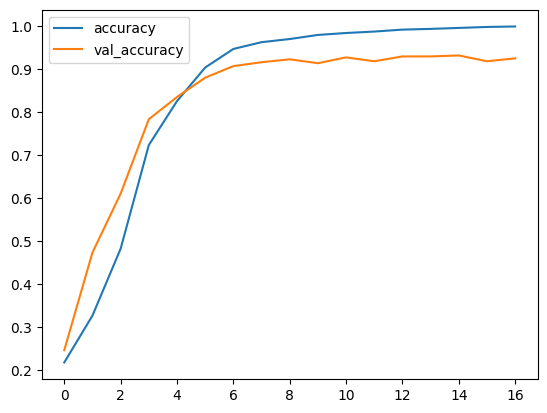

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [ ]:
df.head(5)

,category,text,label,clean_text
0,tech,tv future in the hands of viewers with home th...,4,future hand viewer home theatre system plasma ...
1,business,worldcom boss left books alone former worldc...,0,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,3,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,3,yeading face newcastle cup premiership side ne...
4,entertainment,ocean s twelve raids box office ocean s twelve...,1,ocean twelve raid box office ocean twelve crim...


In [ ]:
df.loc[3,"text"]

'yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round.  the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading  who beat slough in the second round. conference side exeter city  who knocked out doncaster on saturday  will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united  who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park.  a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth  liverpool travel to burnley  crystal palace go to sunderland  fulham face carling cup semi-finalists watford  bolton me

In [ ]:
text=df.loc[3,"text"]
text = clean_data(text)
padded_text=pad_sequences(tk.texts_to_sequences([text]),maxlen=200, truncating="post")

In [ ]:
prediction=model.predict(padded_text)
for item in prediction:
  index=0
  for ele in item:
    print(encoder.inverse_transform([index])+ "—" +str(round(ele*100,4))+ "%")
    index+=1

1/1 [==============================] - 0s 23ms/step
['business—0.002%']
['entertainment—0.0027%']
['politics—0.0%']
['sport—99.9953%']
['tech—0.0%']


In [84]:
# As in the above prediction for sport is 99.99% it is classified in sports which is correct as seen in dataframe